In [2]:
# import necessary packages
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pmdarima as pm
from prophet import Prophet
from pylab import rcParams
from itertools import product
from tqdm import tqdm_notebook

In [3]:
# loading the data - data is provided in excel format
xls = pd.ExcelFile('data_file.xlsx')

In [4]:
# read the data in WaterWorksData sheet and read the right  columns and rows
df1 = pd.read_excel(xls, 'WaterWorksData',skiprows=[1,2,3,4,5],names=['date','yvw','cww','sew','t','r','total'])
df1['date']=pd.to_datetime(df1.date,format="%Y-%m-%d")
df1.head()

,date,yvw,cww,sew,t,r,total
0,2007-01-01,427,234,392,29.0,0.4,1053
1,2007-01-02,372,208,345,28.0,0.0,925
2,2007-01-03,469,285,414,30.0,0.0,1168
3,2007-01-04,491,294,443,33.0,0.0,1228
4,2007-01-05,437,295,424,34.0,0.0,1156


In [5]:
# get basic statistics of the data, here the yvw,cww and sew are three different entitities which records the water 
# consumption in those areas, total consumption would be the summation of all, t - max temperature andr - rainfall
df1.describe()

,yvw,cww,sew,t,r,total
count,4905.000000,4905.000000,4905.000000,4905.000000,4905.000000,4905.000000
mean,402.954740,282.638328,389.996126,21.048909,1.733007,1075.589195
std,68.027304,40.424194,63.353930,7.311028,5.112720,166.953176
min,245.000000,137.000000,218.000000,7.300000,0.000000,754.000000
25%,357.000000,253.000000,343.000000,15.100000,0.000000,955.000000
50%,384.000000,277.000000,377.000000,19.800000,0.000000,1039.000000
75%,431.000000,303.000000,419.000000,25.800000,1.000000,1148.000000
max,778.000000,478.000000,700.000000,45.000000,106.000000,1941.000000


In [6]:
# validate the trend is stationary or non stationary
# H0-non stationary, H1-stationary
result=adfuller(df1.total)
print('ADF Statistics: %f'%result[0])
print('p-value: %f'%result[1])

ADF Statistics: -4.118709
p-value: 0.000902


In [7]:
# failed to reject H1 at 95% confidence interval

<AxesSubplot:xlabel='date'>

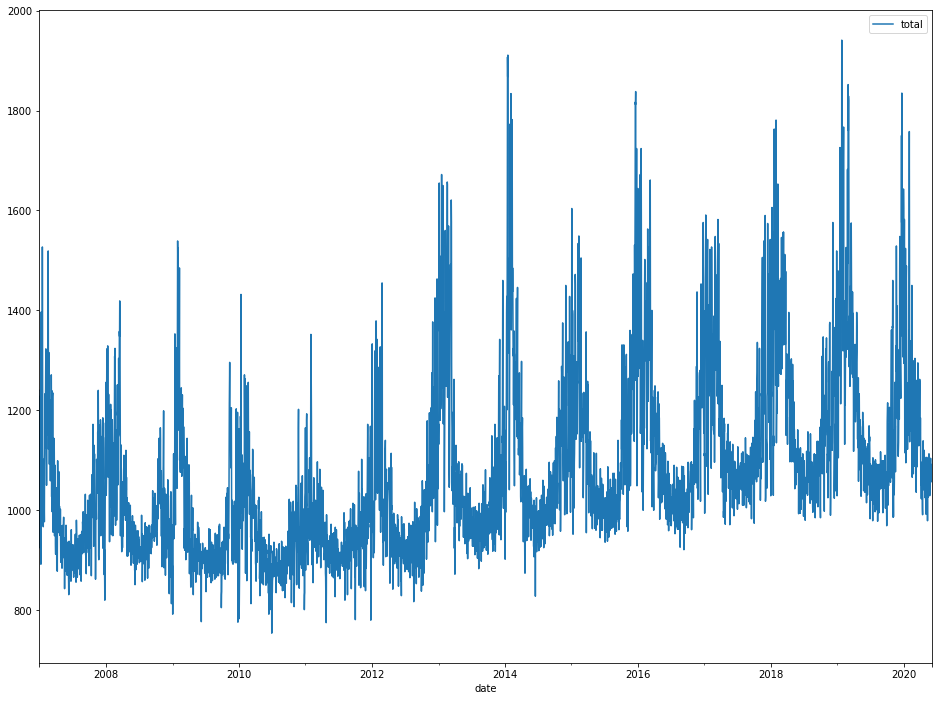

In [9]:
# just see the trend
df1.plot(x='date',y='total',figsize=(16,12))

In [112]:
# Prepare data for FBprophet model
df_day=df1[['date','total']].copy()
# dff.reset_index(inplace=True)
df_day.columns=['ds','y']
df_day.head()

,ds,y
0,2007-01-01,1053
1,2007-01-02,925
2,2007-01-03,1168
3,2007-01-04,1228
4,2007-01-05,1156


In [43]:
# get the monthly data
df_monthly = df1.copy()
df_monthly=df_monthly.resample('MS', on='date').sum()
# df_monthly.index = [df_monthly.index.min()] + list(df_monthly.index[1:])
df_monthly.reset_index(inplace=True)
df_monthly=df_monthly[['date','total']]
df_monthly.columns=['ds','y']
df_monthly.head()

,ds,y
0,2007-01-01,35016
1,2007-02-01,33816
2,2007-03-01,33940
3,2007-04-01,29517
4,2007-05-01,28862


In [196]:
# get only last 3 years data
m = Prophet()
m.fit(df_day[(df_day.ds>'2015-01-01')&(df_day.ds<'2020-05-15')])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


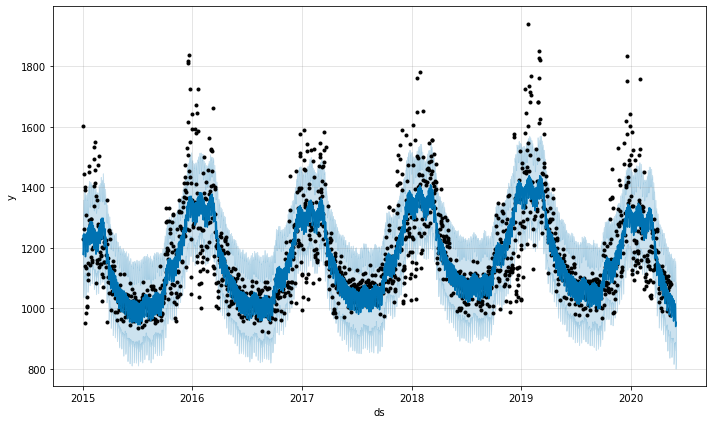

In [197]:
# future = m.make_future_dataframe(periods=30)
# future.tail()

future = m.make_future_dataframe(periods=17)
fcst = m.predict(future)
fig = m.plot(fcst)

In [198]:
# m.plot_components(fcst)
f=fcst[['ds','yhat','yhat_lower','yhat_upper']]
f=f[((f.ds>'2020-05-15')&(f.ds<'2020-06-01'))]
f['y']=df_day[((df_day.ds>'2020-05-15')&(df_day.ds<'2020-06-01'))].y.values
f.set_index('ds',inplace=True)

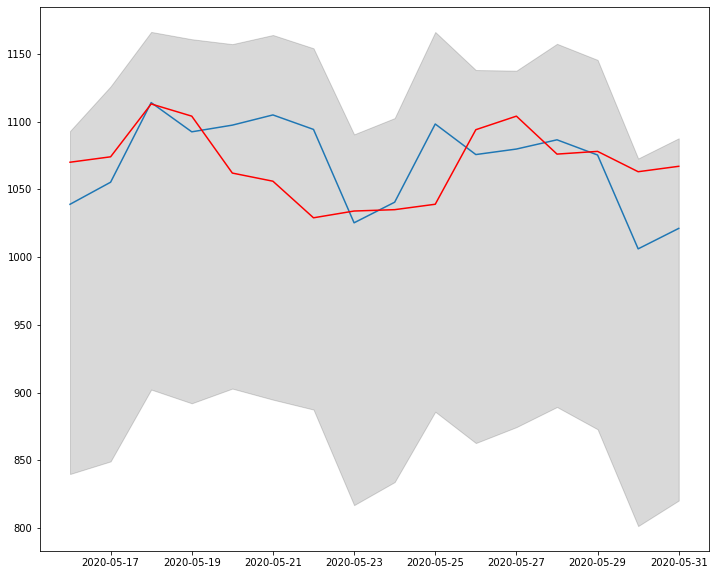

In [203]:

plt.figure(figsize=(12,10))
plt.plot(f.yhat*1.07)
# plt.plot(pred, color='darkgreen')
# plt.plot(f.yhat[-nd:]*.89, color='red')
plt.plot(f.y, color='red')
plt.fill_between(f.index, 
                 f.yhat_lower, 
                 f.yhat_upper, 
                 color='k', alpha=.15)
plt.show()




In [204]:
f['mae']=abs(f.y-f.yhat*1.07)
f['mse']=(f.y-f.yhat*1.07)**2
print(f.mae.mean(),f.mse.mean())

27.73661194580064 1208.5166270631664


In [205]:
f

,yhat,yhat_lower,yhat_upper,y,mae,mse
ds,,,,,,
2020-05-16,970.994637,839.944361,1093.042843,1070,31.035738,963.217058
2020-05-17,986.218195,849.261255,1125.978921,1074,18.746531,351.432429
2020-05-18,1041.120680,902.267733,1166.153154,1113,0.999128,0.998256
2020-05-19,1020.968297,892.124341,1160.768320,1104,11.563923,133.724304
2020-05-20,1025.576174,902.974578,1157.139606,1062,35.366506,1250.789732
2020-05-21,1032.613227,894.828720,1163.875281,1056,48.896152,2390.833727
2020-05-22,1022.627160,887.505490,1154.083440,1029,65.211061,4252.482467
2020-05-23,958.228630,816.990302,1090.564257,1034,8.695366,75.609386
2020-05-24,972.437895,834.008228,1102.561701,1035,5.508547,30.344093


In [150]:
135**2

18225